## 라이브러리 및 공용 함수 정의

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import shutil
import cv2
import pickle
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

def imgcopy_to_path(dataframe , path):
    for img_path in dataframe["file_path"]:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(path, img_name)
        shutil.copy(img_path, save_path)

In [72]:
class CFG:
    img_size = 448
    channels = 3
    batch_size = 5

## 이미지 데이터에 대한 메타데이터 정보 로딩

In [260]:
# 폴더 내 존재하는 이미지 데이터 로딩합니다
df = pd.DataFrame()
df["file_path"] = glob.glob(r"./plant-pathology-2020-fgvc7//images/*")
df["file_name"] = df["file_path"].apply(lambda x: x.split("\\")[-1])
df["img_idx"] = df["file_name"].apply(lambda x: x.split("_")[-1].split(".")[0]).astype("int64")
df["type"] = df["file_name"].apply(lambda x: x.split("_")[0])
df["ext"] = df["file_name"].apply(lambda x: x.split(".")[-1])

# 훈련용 이미지 데이터를 필터링하고 레이블과 병합합니다
df_full = df[df["type"] == "Train"].sort_values("img_idx").reset_index(drop=True)
df_full_labels = pd.read_csv("./plant-pathology-2020-fgvc7/train.csv").rename(columns={"image_id": "file_name"})
df_full_labels["file_name"] = df_full_labels["file_name"].apply(lambda x: x + ".jpg")
df_full = df_full.merge(df_full_labels, how="left", on="file_name")

# 테스트 이미지 데이터를 필터링 합니다
df_test = df[df["type"] == "Test"].sort_values("img_idx").reset_index(drop=True)

In [261]:
df_full.head()

,file_path,file_name,img_idx,type,ext,healthy,multiple_diseases,rust,scab
0,./plant-pathology-2020-fgvc7//images\Train_0.jpg,Train_0.jpg,0,Train,jpg,0,0,0,1
1,./plant-pathology-2020-fgvc7//images\Train_1.jpg,Train_1.jpg,1,Train,jpg,0,1,0,0
2,./plant-pathology-2020-fgvc7//images\Train_2.jpg,Train_2.jpg,2,Train,jpg,1,0,0,0
3,./plant-pathology-2020-fgvc7//images\Train_3.jpg,Train_3.jpg,3,Train,jpg,0,0,1,0
4,./plant-pathology-2020-fgvc7//images\Train_4.jpg,Train_4.jpg,4,Train,jpg,1,0,0,0


In [262]:
df_test.head()

,file_path,file_name,img_idx,type,ext
0,./plant-pathology-2020-fgvc7//images\Test_0.jpg,Test_0.jpg,0,Test,jpg
1,./plant-pathology-2020-fgvc7//images\Test_1.jpg,Test_1.jpg,1,Test,jpg
2,./plant-pathology-2020-fgvc7//images\Test_2.jpg,Test_2.jpg,2,Test,jpg
3,./plant-pathology-2020-fgvc7//images\Test_3.jpg,Test_3.jpg,3,Test,jpg
4,./plant-pathology-2020-fgvc7//images\Test_4.jpg,Test_4.jpg,4,Test,jpg


## 검증용 데이터셋 분할

In [292]:
# 클래스별 비율을 일정하기 맞추기 위해 층화추출 샘플링을 하여 검증셋을 생성합니다
stratVec = df_full["healthy"].astype("str") + "_" + \
    df_full["multiple_diseases"].astype("str") + "_" + \
    df_full["rust"].astype("str") + "_" + \
    df_full["scab"].astype("str")

df_train, df_valid = train_test_split(df_full, test_size=0.2, stratify=stratVec, shuffle=True, random_state=42)

In [293]:
df_train.shape, df_valid.shape

((1456, 9), (365, 9))

In [294]:
df_train.head()

,file_path,file_name,img_idx,type,ext,healthy,multiple_diseases,rust,scab
816,./plant-pathology-2020-fgvc7//images\Train_816...,Train_816.jpg,816,Train,jpg,0,0,1,0
727,./plant-pathology-2020-fgvc7//images\Train_727...,Train_727.jpg,727,Train,jpg,0,0,0,1
928,./plant-pathology-2020-fgvc7//images\Train_928...,Train_928.jpg,928,Train,jpg,0,0,1,0
1725,./plant-pathology-2020-fgvc7//images\Train_172...,Train_1725.jpg,1725,Train,jpg,0,0,1,0
155,./plant-pathology-2020-fgvc7//images\Train_155...,Train_155.jpg,155,Train,jpg,0,0,0,1


In [295]:
df_valid.head()

,file_path,file_name,img_idx,type,ext,healthy,multiple_diseases,rust,scab
551,./plant-pathology-2020-fgvc7//images\Train_551...,Train_551.jpg,551,Train,jpg,1,0,0,0
1537,./plant-pathology-2020-fgvc7//images\Train_153...,Train_1537.jpg,1537,Train,jpg,0,0,0,1
1648,./plant-pathology-2020-fgvc7//images\Train_164...,Train_1648.jpg,1648,Train,jpg,0,1,0,0
878,./plant-pathology-2020-fgvc7//images\Train_878...,Train_878.jpg,878,Train,jpg,0,0,0,1
821,./plant-pathology-2020-fgvc7//images\Train_821...,Train_821.jpg,821,Train,jpg,0,0,1,0


### 메타데이터 저장 및 데이터셋별 이미지 저장


In [80]:
# 이미지에 대한 메타데이터 정보를 담은 데이터프레임을 로컬에 저장합니다
pickleIO(df_full, "./plant-pathology-2020-fgvc7/df_full.pkl", "w")
pickleIO(df_test, "./plant-pathology-2020-fgvc7/df_test.pkl", "w")
pickleIO(df_train.reset_index(drop=True), "./plant-pathology-2020-fgvc7/df_train.pkl", "w")
pickleIO(df_valid.reset_index(drop=True), "./plant-pathology-2020-fgvc7/df_valid.pkl", "w")

In [296]:
# 전체 훈련에 사용되는 데이터와 테스트 데이터에 대한 이미지를 각각 폴더에 나눕니다
save_all_full_path = "./plant-pathology-2020-fgvc7/full_images"
save_all_test_path = './plant-pathology-2020-fgvc7/test_images'

# 폴더를 만들고 저장합니다
if not os.path.exists(save_all_full_path):
    os.makedirs(save_all_full_path, exist_ok=True)
    imgcopy_to_path(df_full, save_all_full_path)

if not os.path.exists(save_all_test_path):
    os.makedirs(save_all_test_path, exist_ok=True)
    imgcopy_to_path(df_test, save_all_test_path)

# 훈련용 데이터와 검증용 데이터셋 대한 이미지를 각각 폴더에 나눕니다
save_dir_train_path = "./plant-pathology-2020-fgvc7/train"
save_dir_valid_path = "./plant-pathology-2020-fgvc7/valid"

# 폴더를 만들고 이미지를 저장합니다
if not os.path.exists(save_dir_train_path):
    os.makedirs(save_dir_train_path, exist_ok=True)
    
if not os.path.exists(save_dir_valid_path):
    os.makedirs(save_dir_valid_path, exist_ok=True)

### 샘플 이미지 확인

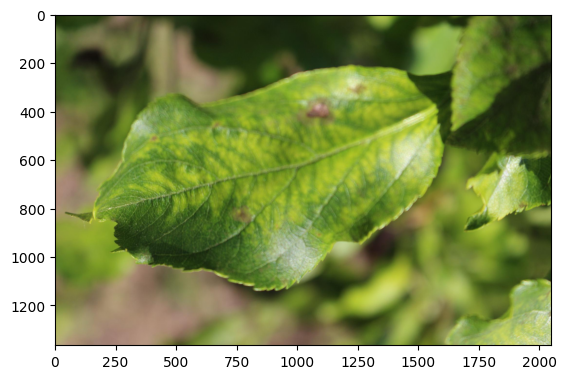

In [14]:
# 샘플로 이미지를 확인합니다
img = plt.imread(df_train["file_path"][0])
plt.imshow(img)
plt.show()

## 데이터 파이프라인 생성

### 클래스별 이미지 저장

In [297]:
# 클래스별로 이미지를 각 폴더에 담기 위해 데이터프레임을 분할합니다
df_train_healthy = df_train.query('healthy==1')
df_train_multiple_diseases = df_train[df_train['multiple_diseases']==1]
df_train_rust = df_train[df_train['rust']==1]
df_train_scab = df_train[df_train['scab']==1]

# 경로를 설정합니다
df_train_healthy_path = './plant-pathology-2020-fgvc7/train/healthy'
df_train_multiple_diseases_path = './plant-pathology-2020-fgvc7/train/multiple_diseases'
df_train_rust_path = './plant-pathology-2020-fgvc7/train/rust'
df_train_scab_path = './plant-pathology-2020-fgvc7/train/scab'

# 훈련용 이미지들을 클래스 폴더에 나누어 저장합니다
if not os.path.exists(df_train_healthy_path):
    # 폴더 생성
    os.makedirs(df_train_healthy_path, exist_ok=True)
    # df_train_healthy 이미지 저장
    imgcopy_to_path(df_train_healthy,df_train_healthy_path )

if not os.path.exists(df_train_multiple_diseases_path):
    # 폴더 생성
    os.makedirs(df_train_multiple_diseases_path, exist_ok=True)
    # df_train_multiple_diseases 이미지 저장
    imgcopy_to_path(df_train_multiple_diseases,df_train_multiple_diseases_path )

if not os.path.exists(df_train_rust_path):
    # 폴더 생성
    os.makedirs(df_train_rust_path, exist_ok=True)
    # df_train_rust 이미지 저장
    imgcopy_to_path(df_train_rust,df_train_rust_path )

if not os.path.exists(df_train_scab_path):
    # 폴더 생성
    os.makedirs(df_train_scab_path, exist_ok=True)
    # df_train_scab 이미지 저장
    imgcopy_to_path(df_train_scab,df_train_scab_path )

In [298]:
# 클래스별로 이미지를 각 폴더에 담기 위해 데이터프레임을 분할합니다
df_valid_healthy =df_valid[df_valid['healthy']==1]
df_valid_multiple_diseases =df_valid[df_valid['multiple_diseases']==1]
df_valid_rust =df_valid[df_valid['rust']==1]
df_valid_scab =df_valid[df_valid['scab']==1]

# 경로를 설정합니다
df_valid_healthy_path = './plant-pathology-2020-fgvc7/valid/healthy'
df_valid_multiple_diseases_path = './plant-pathology-2020-fgvc7/valid/muliple_diseases/'
df_valid_rust_path = './plant-pathology-2020-fgvc7/valid/rust'
df_valid_scab_path = './plant-pathology-2020-fgvc7/valid/scab'

# 검증용 이미지들을 클래스 폴더에 나누어 저장합니다
if not os.path.exists(df_valid_healthy_path):
    # 폴더 생성
    os.makedirs(df_valid_healthy_path, exist_ok=True)
    # df_valid_healthy 이미지 저장
    imgcopy_to_path(df_valid_healthy,df_valid_healthy_path )

if not os.path.exists(df_valid_multiple_diseases_path):
    # 폴더 생성
    os.makedirs(df_valid_multiple_diseases_path, exist_ok=True)
    # df_valid_multiple_diseases 이미지 저장
    imgcopy_to_path(df_valid_multiple_diseases, df_valid_multiple_diseases_path)

if not os.path.exists(df_valid_rust_path):
    # 폴더 생성
    os.makedirs(df_valid_rust_path, exist_ok=True)
    # df_valid_rust_path 이미지 저장
    imgcopy_to_path(df_valid_rust, df_valid_rust_path)

if not os.path.exists(df_valid_scab_path):
    # 폴더 생성
    os.makedirs(df_valid_scab_path, exist_ok=True)
    # df_valid_scab 이미지 저장
    imgcopy_to_path(df_valid_scab, df_valid_scab_path)

### ImageDataGenerator 객체 생성

In [299]:
# 훈련데이터를 위한 이미지 로더를 생성합니다
# 이와 동시에 augmentation 옵션을 조정합니다
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=5,
    shear_range=0.2,
    width_shift_range=0.1,
    fill_mode='nearest'
)
# 이전 클래스별로 할당한 이미지 폴더와 함께 이미지 사이즈, 배치 사이즈를 지정합니다
train_generator = train_datagen.flow_from_directory(
    './plant-pathology-2020-fgvc7/train',
    target_size=(CFG.img_size,CFG.img_size),
    batch_size=CFG.batch_size,
    class_mode='categorical',
)


Found 1456 images belonging to 4 classes.


In [ ]:
# 검증데이터를 위한 이미지 로더를 생성합니다
# 이와 동시에 augmentation 옵션을 조정합니다
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest'
)
# 이전 클래스별로 할당한 이미지 폴더와 함께 이미지 사이즈, 배치 사이즈를 지정합니다
valid_generator=valid_datagen.flow_from_directory(
    './planodt-pathology-2020-fgvc7/valid',
    target_size=(CFG.img_size,CFG.img_size),
    batch_size=CFG.batch_size,
    class_me='categorical',
)

## DNN 모델 정의

In [256]:
# Pre-Trained model을 사용하지 않고 VGGNet 스타일의 아키텍쳐를 차용하여 네트워크 구조를 설계하였습니다.
# 컨볼루션 블럭의 수는 8개이고, 블럭 내부의 연산 순서는 Convolution - BatchNormalization - Activation - Pooling 으로 설정했습니다.
# 특별한 부분은 첫번째 블럭과 마지막 블럭에는 BatchNormalization을 적용하지 않았습니다
# 정확한 이유는 찾지 못했으나 내부 연구결과 해당 구조가 더 성능이 좋았습니다
def create_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(CFG.img_size,CFG.img_size,CFG.channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (1, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))  
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128, (1, 1)))  
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    return model

In [257]:
create_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 446, 446, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 446, 446, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 446, 446, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 223, 223, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 221, 221, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 221, 221, 64)    

## 훈련

In [258]:
# 모델을 초기화하고 컴파일 합니다
# 손실 함수는 Crossentropy를 사용하고 optimizer는 Adam을 사용합니다
model = create_model()
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0002),
    metrics=['accuracy']
)

# Callback 함수를 정의합니다
MODEL_DIR = './model'
if not os.path.exists(MODEL_DIR): 
    os.mkdir(MODEL_DIR)
modelpath = './model/{epoch:02d}-{val_loss:.5f}.hdf5'
checkpointer = ModelCheckpoint(
    filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True
)

In [ ]:
# 훈련합니다
history = model.fit(
    train_generator,
    epochs=150,
    validation_data= valid_generator,
    validation_steps=73,
    callbacks=[checkpointer]
)

### 모델 체크포인트 저장 및 로딩 프로세스 정의

In [ ]:
# history와 상관없이 마지막 모델을 저장할 수 있는 프로세스입니다
model_save = int(input('마지막 모델을 저장하고 싶으면 1을 입력하시오'))
if model_save == 1:
    model.save('./model/thing.hdf5')

In [304]:
# 직접 epoch을 지정하여 저장된 모델을 불러올수 있는 프로세스입니다
model_change = int(input('모델을 불러 오고 싶으면 1 을 입력하시오'))
if model_change == 1:
    model_number= (input('원하는 모델을 입력하십시오'))
    print(f'{model_number}를 입력하셨습니다.')
    model_path = glob.glob(f'./model/{model_number}*')
    model = tf.keras.models.load_model(*model_path)

34를 입력하셨습니다.


### 훈련 결과 시각화

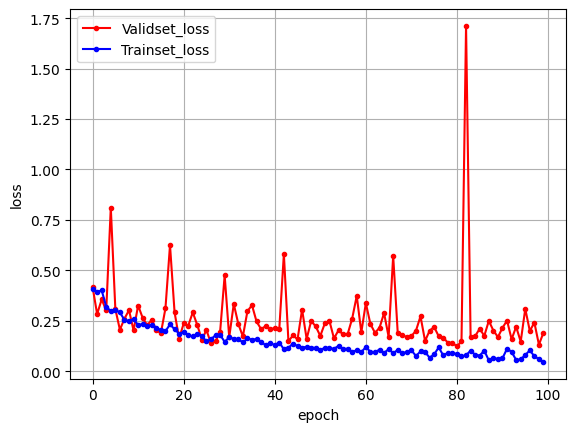

In [41]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Validset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

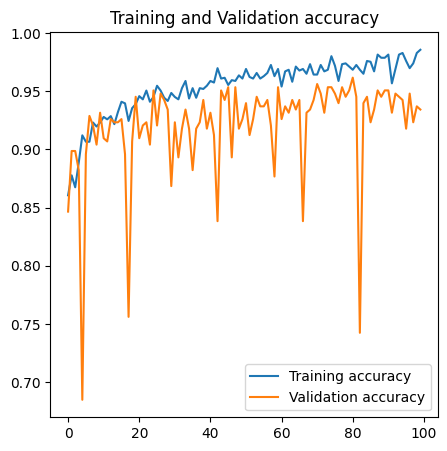

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
x_len = np.arange(len(y_loss))
plt.figure(figsize=(5,5))
plt.plot(x_len, acc,label='Training accuracy')
plt.plot(x_len, val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')
plt.show()

### 검증셋 예측 분포 확인

In [ ]:
# cv2로 이미지를 로딩한다면 BGR 채널을 RGB 채널로 바꿔주어야 하지만
# plt로 이미지를 로딩한다면 그럴필요가 없기 때문에 시간복잡도를 줄일 수 있습니다
# 약 30%의 시간복잡도 감소가 있다는 것을 확인했습니다
full_list = []
for path in df_valid["file_path"]:
    img = plt.imread(path).astype('float32')
    img = img / 255
    img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
    full_list.append(img)
full_list_stack = np.stack(full_list)

In [ ]:
# 검증 데이터셋 이미지를 추론합니다 (CPU mode)
with tf.device('/CPU:0'):
    predict = model.predict(loaded_train_data)

In [ ]:
# 예측데이터와 실제데이터를 구분하여 저장합니다
max_indices = np.argmax(predict, axis=1)
predictions = np.zeros_like(predict)
predictions[np.arange(len(predict)), max_indices] = 1
train_output = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
pred_y = train_output[:]
y = df_valid.iloc[:, 5:]

# 넘파이 객체로 변환합니다
pred_y = pred_y.to_numpy().argmax(axis=1)
y = y.to_numpy().argmax(axis=1)

In [ ]:
# 오차행렬을 출력합니다
cm = confusion_matrix(y, pred_y)
print("훈련용 데이터 오차행렬:\n", cm)

In [ ]:
# 퍼센티지로 스케일된 행렬을 확인합니다
cm = confusion_matrix(y, pred_y, normalize="all")

In [ ]:
# 분류 예측 리포트를 출력합니다
print("훈련용 데이터 분류예측 리포트:\n", classification_report(y, pred_y))

## 추론

In [81]:
# 테스트 이미지 데이터 로딩
test_list = []
for path in df_test["file_path"]:
    img = plt.imread(path).astype('float32')
    img = img / 255
    img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
    test_list.append(img)
test_list_stack = np.stack(test_list)

In [84]:
test_images_stack = './plant-pathology-2020-fgvc7/test_images_stack.pkl'
chagne_image_size =input('이미지 사이즈를 변경하고 싶으면 1을 입력하십시오.')
if chagne_image_size=='1':
    pickleIO(test_list_stack ,test_images_stack,'w' )

In [8]:
test_images_stack = './plant-pathology-2020-fgvc7/test_images_stack.pkl'
loaded_test_data = pickleIO(None, test_images_stack, 'r')

In [244]:
# 테스트셋 이미지를 추론합니다
with tf.device('/CPU:0'):
    predict = model.predict(loaded_test_data)

57/57 [==============================] - 244s 4s/step


In [245]:
# 제출 포맷에 맞게 입력한 후 CSV로 내보냅니다
output = pd.DataFrame(predict)
output = output[['healthy', 'multiple_diseases', 'rust', 'scab']]
output = pd.concat([df_test[['file_name']], output], axis=1)
output = output.rename(columns={'file_name': 'image_id'})
output['image_id'] = output['image_id'].apply(lambda x: x.split('.')[0])
output.to_csv("submission2.csv", index=False)

### 테스트 예측 클래스 분포 시각화

In [ ]:
answer = []
answer_2 = []
num_above_80 = []
for i in range(len(predict)):
    answer.append(predict[i].argmax())
    answer_2.append(predict[i].max())
num_count = {i: 0 for i in range(4)}

for i,b in zip(answer,answer_2):
    if i in num_count:
         num_count[i] += 1
    if b >= 0.9:
        num_above_80.append(i)

0.843


{0: 380, 1: 97, 2: 726, 3: 618}

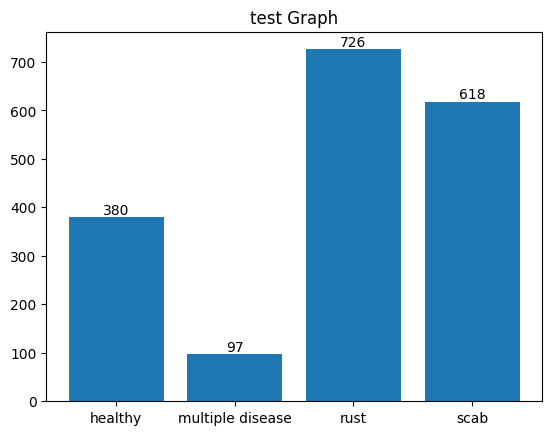

In [302]:
name=  'healthy,multiple disease,rust,scab'.split(',')
data = num_count

# 데이터 분리
x = name # x축 데이터
y = list(data.values()) # y축 데이터

# 바그래프 그리기
plt.bar(x, y)

# 그래프에 레이블 추가
for i, v in enumerate(y):
    plt.text(i, v, str(v), ha='center', va='bottom')

# 그래프 제목과 축 레이블 설정
plt.title('test Graph')

# 그래프 보여주기
plt.show()

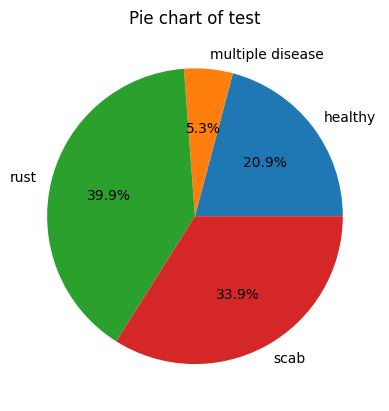

In [303]:
data = num_count

# 데이터 분리
labels = name # 레이블
sizes = [val / 1821 for val in data.values()] # 크기 (1821로 나눔)

# 파이 차트 그리기
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# 차트 제목 설정
plt.title('Pie chart of test')

# 파이 차트 보여주기
plt.show()